Hw 2, Problem 3: Lifting Map and Delaunay Triangulation

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv
from scipy.spatial import Delaunay
from scipy.linalg import eigh

Part a)

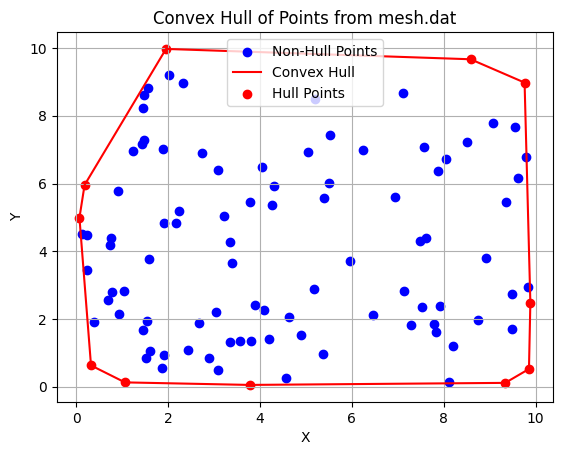

In [18]:
def get_cross_product(p1, p2, p3):
    return (p2[0] - p1[0]) * (p3[1] - p1[1]) - (p2[1] - p1[1]) * (p3[0] - p1[0])

def get_slope(p1, p2):
    if p1[0] == p2[0]:
        return float('inf')
    return (p2[1] - p1[1]) / (p2[0] - p1[0])

# 2D Graham Scan
def compute_convex_hull(points):
    # Step 1: Sort the points
    points.sort(key=lambda x: (x[0], x[1]))
    
    # Step 2: Get the start point (lowest lexicographical point)
    start = points.pop(0)
    hull = [start]

    # Step 3: Sort remaining points based on polar angle with the start point
    points.sort(key=lambda p: (get_slope(start, p), p[1], p[0]))

    # Step 4: Build the hull
    for pt in points:
        hull.append(pt)
        # Ensure convexity by checking the cross product
        while len(hull) > 2 and get_cross_product(hull[-3], hull[-2], hull[-1]) < 0:
            hull.pop(-2)
    
    return hull

def read_points_from_file(filename):
    points = []
    with open(filename, 'r') as f:
        reader = csv.reader(f, delimiter=' ')
        next(reader)  # Skip the first row (header)
        for row in reader:
            # Convert the x, y values to floats and append as a tuple
            points.append((float(row[0]), float(row[1])))
            
    return points

points = read_points_from_file('mesh.dat')
# print(points)
hull = compute_convex_hull(points)
# print(hull)

def plot_points_with_hull(points, hull):
    # Separate the points on the convex hull from the others
    hull_set = set(hull)
    non_hull_points = [pt for pt in points if pt not in hull_set]
    
    # Plot all points (non-hull points in one color)
    x_non_hull, y_non_hull = zip(*non_hull_points) if non_hull_points else ([], [])
    plt.scatter(x_non_hull, y_non_hull, color='blue', label='Non-Hull Points')
    
    # Plot the convex hull points (different color, connected by lines)
    x_hull, y_hull = zip(*hull)
    plt.plot(x_hull + (x_hull[0],), y_hull + (y_hull[0],), color='red', label='Convex Hull')
    plt.scatter(x_hull, y_hull, color='red', marker='o', label='Hull Points')
    
    # Add labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Convex Hull of Points from mesh.dat')
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_points_with_hull(points, hull)

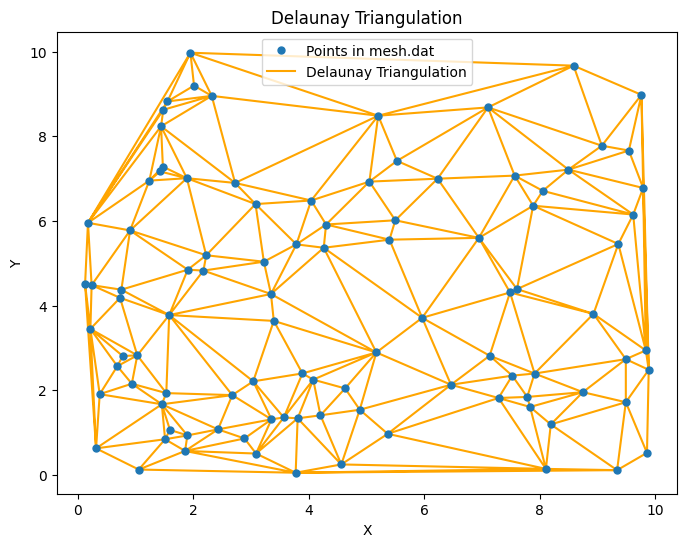

In [19]:
points_np = np.array(points)

# Create the Delaunay triangulation
triangulation = Delaunay(points_np)

# Plot the points and the Delaunay triangulation
plt.figure(figsize=(8, 6))
plt.plot(points_np[:, 0], points_np[:, 1], 'o', markersize=5, label='Points in mesh.dat')
plt.triplot(points_np[:, 0], points_np[:, 1], triangulation.simplices, color='orange', label='Delaunay Triangulation')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Delaunay Triangulation')
plt.legend()
plt.show()

Part b)

In [50]:
# # Lifting map function
# def lifting_map(x, y):
#     return x**2 + y**2

# # Triangle area functions
# def triangle_area_2d(p1, p2, p3):
#     return 0.5 * abs(p1[0] * (p2[1] - p3[1]) + p2[0] * (p3[1] - p1[1]) + p3[0] * (p1[1] - p2[1]))

# def triangle_area_3d(p1, p2, p3):
#     v1 = np.array([p2[0] - p1[0], p2[1] - p1[1], p2[2] - p1[2]])
#     v2 = np.array([p3[0] - p1[0], p3[1] - p1[1], p3[2] - p1[2]])
#     cross_product = np.cross(v1, v2)
#     return 0.5 * np.linalg.norm(cross_product)

# # Calculate area ratios for each triangle
# area_ratios = np.zeros(len(triangulation.simplices))
# for i, simplex in enumerate(triangulation.simplices):
#     p1 = points_np[simplex[0]]
#     p2 = points_np[simplex[1]]
#     p3 = points_np[simplex[2]]
    
#     area_2d = triangle_area_2d(p1, p2, p3)
    
#     p1_3d = (p1[0], p1[1], lifting_map(p1[0], p1[1]))
#     p2_3d = (p2[0], p2[1], lifting_map(p2[0], p2[1]))
#     p3_3d = (p3[0], p3[1], lifting_map(p3[0], p3[1]))
    
#     area_3d = triangle_area_3d(p1_3d, p2_3d, p3_3d)
    
#     area_ratios[i] = area_3d / area_2d

# # print(len(area_ratios))
# # print(len(triangulation.simplices))
# # print(area_ratios)
# # print(max(area_ratios))

# # Step 1: Set the number of top values to exclude
# n = 3  # Adjust as needed

# # Step 2: Find the top n highest values in area_ratios
# top_n_values = np.partition(area_ratios, -n)[-n:]  # This gives the top n values

# # Step 3: Mask these top n values by replacing them with NaN
# area_ratios_filtered = np.copy(area_ratios)
# for value in top_n_values:
#     area_ratios_filtered[area_ratios == value] = np.nan

# # Step 4: Plot the area ratio heatmap
# plt.figure(figsize=(8, 6))
# plt.tripcolor(points_np[:, 0], points_np[:, 1], triangulation.simplices, facecolors=area_ratios_filtered, cmap='viridis', edgecolors='k')
# plt.colorbar(label='Area Ratio (3D / 2D)')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title(f'Area Ratio Heatmap (Top {n} Values Excluded)')
# plt.show()

In [94]:
# Remember to constrain points from [-2, 2]

# Read the data from the file
data = np.loadtxt('mesh.dat', skiprows=1)
data = data[(data[:, 0] < 2) & (data[:, 1] < 2)]
X = data[:, 0] # define x and y
Y = data[:, 1]

#2D Graham scan 
def isCCW(v_a, v_b):
    crossprod = v_a[0]*v_b[1] - v_a[1]*v_b[0]
    return(crossprod>0)

def Grahamscan(data):
    Y = data[:, 1]
    ii = np.argmin(Y)        #find lowest y coordinate
    ipt = data[ii]
    length = len(data)
    angarr = np.zeros(length)
    for j in range(length):       #i'll take the dot product to represent an angle. a is the unit vector in x direction, b is displacement ot new pt
        a = [1,0]
        b = data[j]-ipt
        normb = np.sqrt(b[0]**2 + b[1]**2)
        if(j==ii):
            angarr[j] = -999
        else:
            angarr[j] = np.dot(a,b) / normb
    sort_indices = np.argsort(angarr)
    data_sorted = data[sort_indices]
    
    hull = []                           #data_sorted[0:3, :]   didn't do this since you can only append to lists
    for k in range(3):
        hull.append(data_sorted[k])    #adds first three points
        
    for i in range(3, length):
        cont=True
        while(cont):
            v_next = data_sorted[i]-hull[-1]
            v_prev = hull[-1]-hull[-2]
            if(isCCW(v_prev,v_next)):
                hull.pop()
                cont = True
            else:
                cont = False
                hull.append(data_sorted[i])
                
    
    hull.append(data_sorted[0]) #handles last step
    return hull
    

hull = np.array(Grahamscan(data))  #plots
X_f = hull[:, 0]
Y_f = hull[:, 1]

In [52]:
points = np.column_stack((X, Y))
tri = Delaunay(points)

In [65]:
def triangle_area(p1, p2, p3): #input is numpy arrays p = [x, y, z]
    
    # Calculate the vectors for two sides of the triangle, and their cross product
    v1 = p2 - p1
    v2 = p3 - p1
    cross_product = np.cross(v1, v2)
    
    area = 0.5 * np.linalg.norm(cross_product)    #area is half the parallelogram they form
    return area

def lift_f(x, y):
    return x**2 + y**2

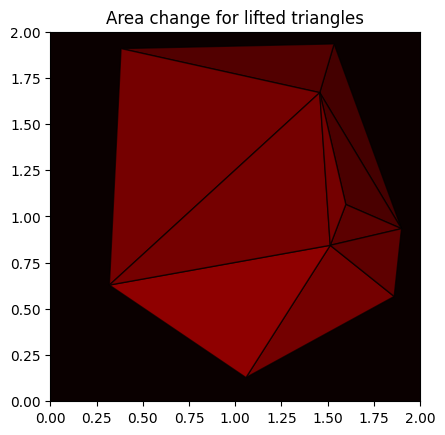

In [54]:
tricoords = tri.simplices

# Plot heat map background
plt.imshow(np.zeros((2, 2)), cmap='hot', origin='lower', extent=(0, 2, 0, 2))

for t in tricoords:
    p1 = points[t[0]]
    p2 = points[t[1]]
    p3 = points[t[2]]
    #print("Points: ", p1, p2, p3)
    og_area = triangle_area(p1,p2,p3)
    #print("Area: ", og_area)

    z1 = lift_f(p1[0], p1[1])       
    lifted_p1 = np.append(p1, z1)
    z2 = lift_f(p2[0], p2[1])      
    lifted_p2 = np.append(p2, z2)
    z3 = lift_f(p3[0], p3[1])       
    lifted_p3 = np.append(p3, z3)

    new_area = triangle_area(lifted_p1, lifted_p2, lifted_p3)

    redness = (og_area/new_area)

    x_coords = [p1[0], p2[0], p3[0]]  # Extract x and y coordinates of the points
    y_coords = [p1[1], p2[1], p3[1]]
    plt.fill(x_coords, y_coords, color=(2*redness, 0, 0), edgecolor='black', alpha=0.7)    # Plot and fill the triangle, using an RGB tuple
    plt.title('Area change for lifted triangles')
    
plt.show()

Part c)

The induced metric can be calculated by taking derivatives (d/dx and d/dy) of $\vec{r} = (x, y, x^2 + y^2)$, and performing dot products.<br>
$g_{xx} = 1+4x^2$ <br>
$g_{xy} = g_{yx} = 4xy$ <br>
$g_{yy} = 1+4y^2$

In [48]:
# Compute the coefficients of the induced metric at a point (x, y)
def induced_metric(x, y):
    E = 1 + 4*x**2
    F = 2*x*y
    G = 1 + 4*y**2
    return E, F, G

# Calculate the induced metric for each point
metrics = [induced_metric(x, y) for x, y in points_np]

# Print the metrics for each point
for i, (x, y) in enumerate(points_np):
    E, F, G = metrics[i]
    print(f"Point ({x}, {y}): E = {E}, F = {F}, G = {G}")

Point (0.318775, 0.628921): E = 1.4064700024999999, F = 0.4009685835499999, G = 2.5821664969639997
Point (0.220598, 3.450224): E = 1.1946539104159999, F = 1.522225027904, G = 48.616182600704
Point (0.381927, 1.908477): E = 1.583472933316, F = 1.457797790358, G = 15.569137838116
Point (0.128699, 4.507505): E = 1.066253730404, F = 1.16022277199, G = 82.27040530010001
Point (1.057869, 0.128336): E = 5.476347284644, F = 0.271525351968, G = 1.065880515584
Point (0.686874, 2.569727): E = 2.8871835675039996, F = 3.5301573267959996, G = 27.413987418115997
Point (0.937792, 2.15556): E = 4.517815341056, F = 4.04293384704, G = 19.5857556544
Point (0.780256, 2.810086): E = 3.435197702144, F = 4.385172924032, G = 32.586333309584006
Point (0.24177, 4.484384): E = 1.2338109316, F = 2.1683790393600004, G = 81.43879943782402
Point (1.513863, 0.843987): E = 10.167124731076, F = 2.555361383562, G = 3.8492562246760005
Point (1.598117, 1.064985): E = 11.215911782756, F = 3.4039412664900004, G = 5.536772200

Part d)

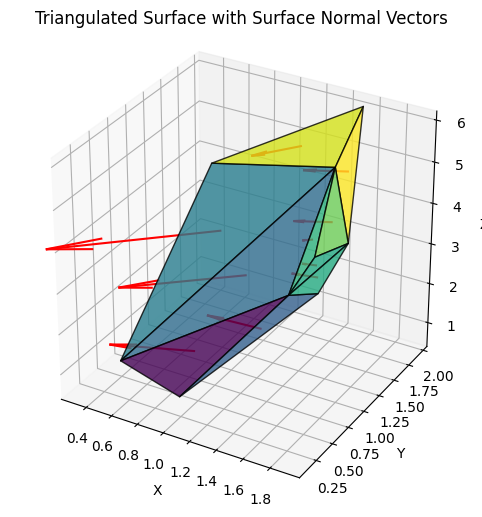

In [ ]:
zvals = []
for pt in points:
    zvals.append(lift_f(pt[0], pt[1]))

lifted_points = np.column_stack((X, Y, np.array(zvals)))
tri_3D = Delaunay(lifted_points[:, :2])  # Use only the x, y coordinates for triangulation

# Plot the triangulated surface in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1, 1, 1])
# Use plot_trisurf to create the surface
ax.plot_trisurf(lifted_points[:, 0], lifted_points[:, 1], lifted_points[:, 2], triangles=tri_3D.simplices, cmap='viridis', alpha=0.8, edgecolor='k')

def triangle_normal(p1, p2, p3): #input is numpy arrays p = [x, y, z]
    
    # Calculate the vectors for two sides of the triangle, and their cross product
    v1 = p2 - p1
    v2 = p3 - p1
    cross_product = np.cross(v1, v2)
    return cross_product

for t in tri_3D.simplices:
    p1 = lifted_points[t[0]]
    p2 = lifted_points[t[1]]
    p3 = lifted_points[t[2]]
    #print("Pt: ", p1, p2, p3)
    normal = triangle_normal(p1, p2, p3) / 3.0     #3 is an arbitrary scale factor for aesthetics
    if(normal[2]<0):
        normal = normal*-1    #flip if facing downwards
    center = (p1 + p2 + p3) / 3     # Calculate the center of the triangle
    
    # Plot the normal vector
    ax.quiver(
        center[0], center[1], center[2],  # Origin of the vector
        normal[0], normal[1], normal[2],  # Direction of the vector
        color='red'
    )

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Triangulated Surface with Surface Normal Vectors')
plt.show()

Part e)

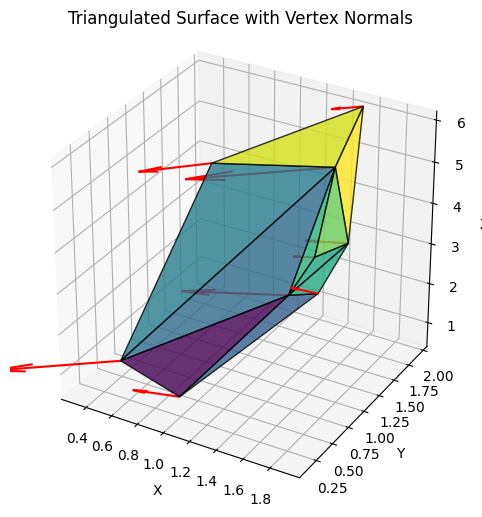

In [ ]:
# Plot the triangulated surface in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1, 1, 1])
# Use plot_trisurf to create the surface
ax.plot_trisurf(lifted_points[:, 0], lifted_points[:, 1], lifted_points[:, 2], triangles=tri_3D.simplices, cmap='viridis', alpha=0.8, edgecolor='k')

vertex_norms = np.zeros(lifted_points.shape)  #creating a copy to store the averaged values

for t in tri_3D.simplices:
    p1 = lifted_points[t[0]]
    p2 = lifted_points[t[1]]
    p3 = lifted_points[t[2]]
    #print("Pt: ", p1, p2, p3)
    normal = triangle_normal(p1, p2, p3) / 9.0     #3 is an arbitrary scale factor for aesthetics
    if(normal[2]<0):
        normal = normal*-1    #flip if facing downwards

    vertex_norms[t[0]] += normal
    vertex_norms[t[1]] += normal
    vertex_norms[t[2]] += normal

for i in range(len(vertex_norms)):
    v = vertex_norms[i]
    pt = lifted_points[i]
    # Plot the normal vector
    ax.quiver(
        pt[0], pt[1], pt[2],  # Origin of the vector
        v[0], v[1], v[2],  # Direction of the vector
        color='red'
    )

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Triangulated Surface with Vertex Normals')
plt.show()

Part f)

In [62]:
# Analytical lifting map and derivatives
def lifting_map(x, y):
    return x**2 + y**2

# Analytical normal vector
def surface_normal(x, y):
    # Compute the unit normal vector analytically
    nx, ny, nz = -2*x, -2*y, 1
    norm = np.sqrt(nx**2 + ny**2 + nz**2)
    return np.array([nx / norm, ny / norm, nz / norm])

# Predefined second derivatives of r(x, y)
def second_derivative_xx():
    return np.array([0, 0, 2])  # d^2r/dx^2

def second_derivative_yy():
    return np.array([0, 0, 2])  # d^2r/dy^2

def second_derivative_xy():
    return np.array([0, 0, 0])  # d^2r/dxdy

# Second fundamental form components
def second_fundamental_form(x, y):
    n = surface_normal(x, y)  # Surface normal at (x, y)
    L = -np.dot(n, second_derivative_xx())  # Curvature in the x-direction
    M = -np.dot(n, second_derivative_xy())  # Mixed curvature
    N = -np.dot(n, second_derivative_yy())  # Curvature in the y-direction
    return L, M, N

# Loop over points in the triangulation
second_form_values = []
for x, y in points_np:  # points_np is the array of 2D points from your triangulation
    L, M, N = second_fundamental_form(x, y)
    second_form_values.append((L, M, N))

# Convert to a NumPy array for easy processing
second_form_values = np.array(second_form_values)

# Example: Print a few values of (L, M, N)
print("First few second fundamental form values (L, M, N):")
print(second_form_values[:5])

First few second fundamental form values (L, M, N):
[[-1.15689368 -0.         -1.15689368]
 [-0.28626738 -0.         -0.28626738]
 [-0.49763238 -0.         -0.49763238]
 [-0.22041106 -0.         -0.22041106]
 [-0.84954778 -0.         -0.84954778]]


Part g)

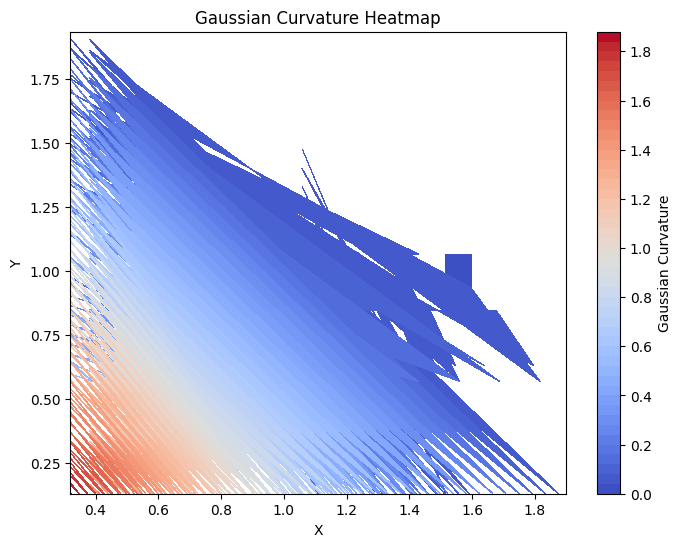

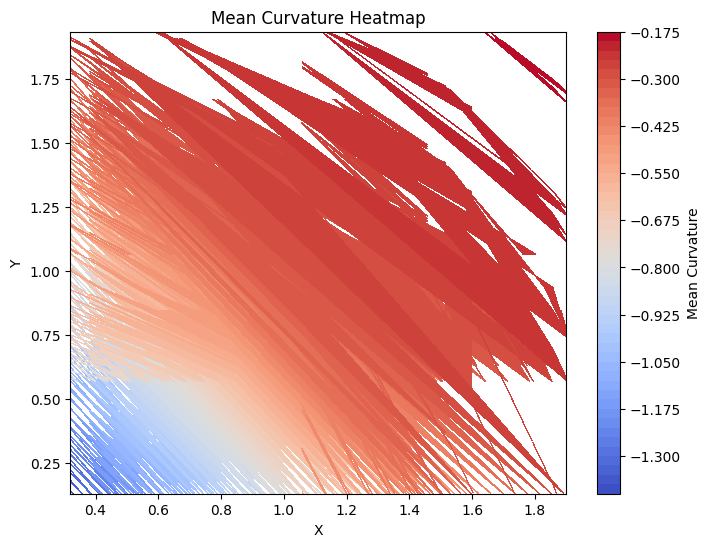

In [108]:
# Define surface normal for z = x^2 + y^2
def surface_normal(x, y):
    dz_dx = 2 * x
    dz_dy = 2 * y
    n = np.array([-dz_dx, -dz_dy, 1])  # Normal vector
    return n / np.linalg.norm(n)

# Define first and second fundamental forms
def first_fundamental_form(x, y):
    E = 1 + 4 * x**2
    F = 4 * x * y
    G = 1 + 4 * y**2
    return np.array([[E, F], [F, G]])

def second_fundamental_form(x, y):
    n = surface_normal(x, y)
    d2r_xx = np.array([0, 0, 2])  # d^2r/dx^2
    d2r_yy = np.array([0, 0, 2])  # d^2r/dy^2
    d2r_xy = np.array([0, 0, 0])  # d^2r/dxdy
    L = -np.dot(n, d2r_xx)
    M = -np.dot(n, d2r_xy)
    N = -np.dot(n, d2r_yy)
    return np.array([[L, M], [M, N]])

# Assuming X and Y are 1D arrays
X_grid, Y_grid = np.meshgrid(X, Y)  # Create a 2D grid from X and Y

# Flatten the grid for iteration
X_flat = X_grid.flatten()
Y_flat = Y_grid.flatten()

# Initialize arrays with NaN values to handle skipped points
gaussian_curvature = np.full(X_flat.size, np.nan)
mean_curvature = np.full(X_flat.size, np.nan)
principal_curvatures = np.full((X_flat.size, 2), np.nan)  # For k1, k2

# Loop through the flattened X and Y arrays
for idx, (x, y) in enumerate(zip(X_flat, Y_flat)):
    I = first_fundamental_form(x, y)
    II = second_fundamental_form(x, y)

    # Ensure I is invertible
    if np.linalg.cond(I) > 1e10:  # Skip ill-conditioned points
        continue

    # Shape operator: S = II * I^-1
    S = np.linalg.inv(I) @ II
    S = 0.5 * (S + S.T)  # Symmetrize

    # Principal curvatures: eigenvalues of S
    eigenvalues, _ = eigh(S)
    k1, k2 = eigenvalues
    principal_curvatures[idx] = (k1, k2)

    # Gaussian and mean curvatures
    gaussian_curvature[idx] = k1 * k2
    mean_curvature[idx] = 0.5 * (k1 + k2)

# Reshape curvature arrays to match the 2D grid
gaussian_curvature = gaussian_curvature.reshape(X_grid.shape)
mean_curvature = mean_curvature.reshape(X_grid.shape)
principal_curvatures = principal_curvatures.reshape(X_grid.shape + (2,))

# Plot Gaussian curvature
plt.figure(figsize=(8, 6))
plt.contourf(X_grid, Y_grid, gaussian_curvature, levels=50, cmap='coolwarm')
plt.colorbar(label='Gaussian Curvature')
plt.title('Gaussian Curvature Heatmap')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Plot Mean curvature
plt.figure(figsize=(8, 6))
plt.contourf(X_grid, Y_grid, mean_curvature, levels=50, cmap='coolwarm')
plt.colorbar(label='Mean Curvature')
plt.title('Mean Curvature Heatmap')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Example:

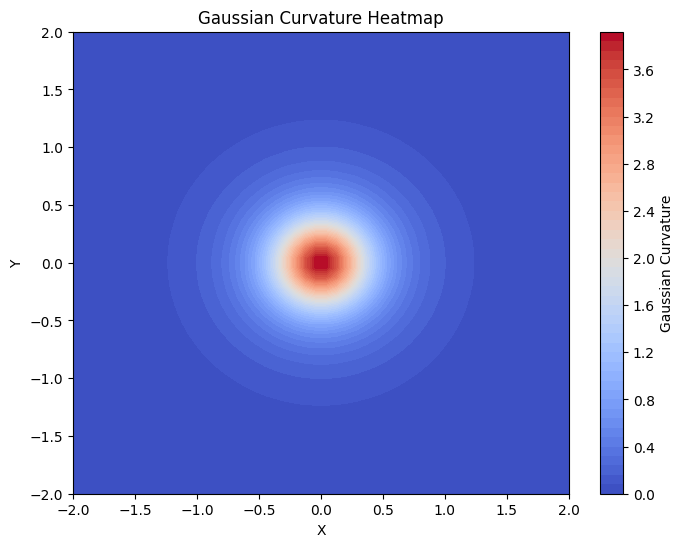

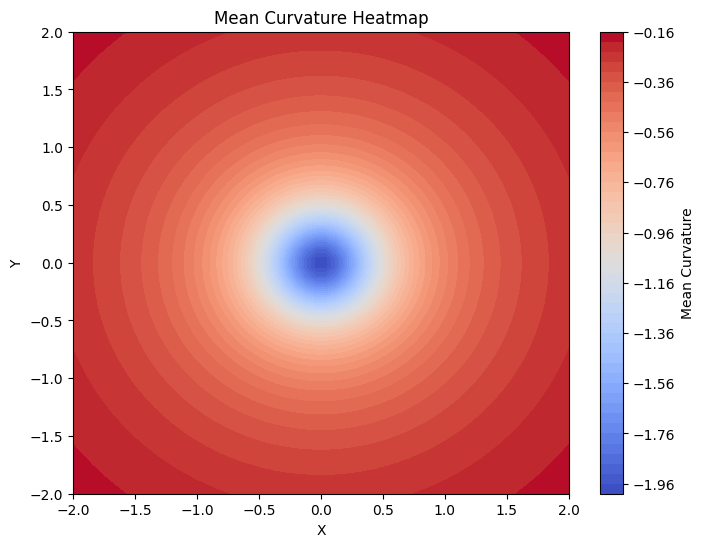

In [109]:
import numpy as np
import matplotlib.pyplot as plt

# Define the surface function z = f(x, y)
def surface_function(x, y):
    return x**2 + y**2  # Example: Paraboloid

# Define the first fundamental form
def first_fundamental_form(x, y):
    E = 1 + 4 * x**2
    F = 4 * x * y
    G = 1 + 4 * y**2
    return np.array([[E, F], [F, G]])

# Define the second fundamental form
def second_fundamental_form(x, y):
    n = surface_normal(x, y)
    d2r_xx = np.array([0, 0, 2])  # d^2r/dx^2
    d2r_yy = np.array([0, 0, 2])  # d^2r/dy^2
    d2r_xy = np.array([0, 0, 0])  # d^2r/dxdy
    L = -np.dot(n, d2r_xx)
    M = -np.dot(n, d2r_xy)
    N = -np.dot(n, d2r_yy)
    return np.array([[L, M], [M, N]])

# Define the surface normal vector
def surface_normal(x, y):
    normal = np.array([-2*x, -2*y, 1])
    return normal / np.linalg.norm(normal)

# Create a grid of points
x = np.linspace(-2, 2, 50)
y = np.linspace(-2, 2, 50)
X, Y = np.meshgrid(x, y)

# Compute Gaussian and mean curvatures
gaussian_curvature = np.zeros(X.shape)
mean_curvature = np.zeros(X.shape)
principal_curvatures = np.zeros(X.shape + (2,))

for i in range(len(x)):
    for j in range(len(y)):
        xi, yi = X[i, j], Y[i, j]
        I = first_fundamental_form(xi, yi)
        II = second_fundamental_form(xi, yi)
        
        # Compute shape operator: S = II * I^-1
        S = np.linalg.inv(I) @ II
        S = 0.5 * (S + S.T)  # Symmetrize

        # Principal curvatures: eigenvalues of S
        k1, k2 = eigh(S)[0]
        principal_curvatures[i, j] = (k1, k2)

        # Gaussian and mean curvatures
        gaussian_curvature[i, j] = k1 * k2
        mean_curvature[i, j] = 0.5 * (k1 + k2)

# Plot Gaussian curvature
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, gaussian_curvature, levels=50, cmap='coolwarm')
plt.colorbar(label='Gaussian Curvature')
plt.title('Gaussian Curvature Heatmap')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Plot Mean curvature
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, mean_curvature, levels=50, cmap='coolwarm')
plt.colorbar(label='Mean Curvature')
plt.title('Mean Curvature Heatmap')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


Part h)

In [96]:
def lift_f2(x, y):
    return x**2 + x*y + y**2

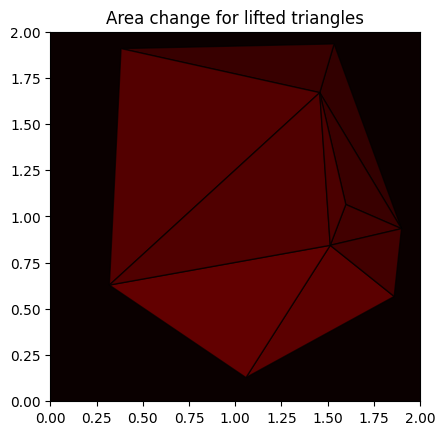

In [97]:
# Plot heat map background
plt.imshow(np.zeros((2, 2)), cmap='hot', origin='lower', extent=(0, 2, 0, 2))

for t in tricoords:
    p1 = points[t[0]]
    p2 = points[t[1]]
    p3 = points[t[2]]
    og_area = triangle_area(p1,p2,p3)

    z1 = lift_f2(p1[0], p1[1])       
    lifted_p1 = np.append(p1, z1)
    z2 = lift_f2(p2[0], p2[1])      
    lifted_p2 = np.append(p2, z2)
    z3 = lift_f2(p3[0], p3[1])       
    lifted_p3 = np.append(p3, z3)

    new_area = triangle_area(lifted_p1, lifted_p2, lifted_p3)

    redness = (og_area/new_area)

    x_coords = [p1[0], p2[0], p3[0]]  # Extract x and y coordinates of the points
    y_coords = [p1[1], p2[1], p3[1]]
    plt.fill(x_coords, y_coords, color=(2*redness, 0, 0), edgecolor='black', alpha=0.7)    # Plot and fill the triangle, using an RGB tuple
    plt.title('Area change for lifted triangles')
    
plt.show()

In [100]:
# Calculate the induced metric for each point
points_np2 = np.column_stack((X.flatten(), Y.flatten()))

metrics = [induced_metric(x, y) for x, y in points_np2]

# Print the metrics for each point
for i, (x, y) in enumerate(points_np2):
    E, F, G = metrics[i]
    print(f"Point ({x}, {y}): E = {E}, F = {F}, G = {G}")

Point (1.598117, 1.064985): E = 11.215911782756, F = 3.4039412664900004, G = 5.536772200900001
Point (0.381927, 1.908477): E = 1.583472933316, F = 1.457797790358, G = 15.569137838116
Point (1.899378, 0.9341): E = 15.430547147536, F = 3.5484179796000004, G = 4.4901712400000005
Point (1.859855, 0.567303): E = 14.836242484100001, F = 2.11020264213, G = 2.2873307752359997
Point (1.534832, 1.93382): E = 10.422837072896, F = 5.93617763648, G = 15.958639169600001
Point (1.057869, 0.128336): E = 5.476347284644, F = 0.271525351968, G = 1.065880515584
Point (1.457157, 1.670074): E = 9.493226090596, F = 4.867120039236, G = 12.156588661904001
Point (0.318775, 0.628921): E = 1.4064700024999999, F = 0.4009685835499999, G = 2.5821664969639997
Point (1.513863, 0.843987): E = 10.167124731076, F = 2.555361383562, G = 3.8492562246760005


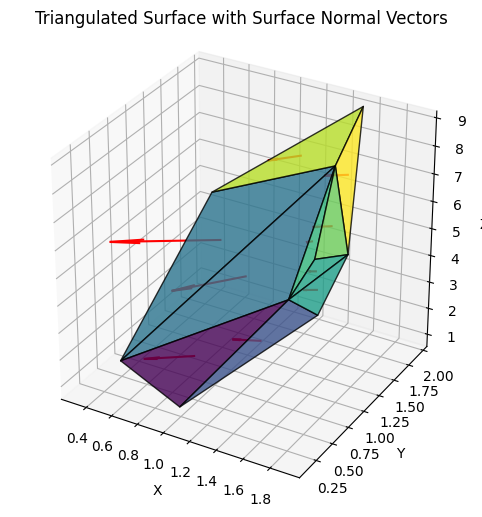

In [105]:
zvals2 = []
for pt in points:
    zvals2.append(lift_f2(pt[0], pt[1]))

lifted_points2 = np.column_stack((X, Y, np.array(zvals2)))
tri_3D2 = Delaunay(lifted_points2[:, :2])  # Use only the x, y coordinates for triangulation

# Plot the triangulated surface in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1, 1, 1])
# Use plot_trisurf to create the surface
ax.plot_trisurf(lifted_points2[:, 0], lifted_points2[:, 1], lifted_points2[:, 2], triangles=tri_3D2.simplices, cmap='viridis', alpha=0.8, edgecolor='k')

for t in tri_3D2.simplices:
    p1 = lifted_points2[t[0]]
    p2 = lifted_points2[t[1]]
    p3 = lifted_points2[t[2]]
    normal = triangle_normal(p1, p2, p3) / 3.0     #3 is an arbitrary scale factor for aesthetics
    if(normal[2]<0):
        normal = normal*-1    #flip if facing downwards
    center = (p1 + p2 + p3) / 3     # Calculate the center of the triangle
    
    # Plot the normal vector
    ax.quiver(
        center[0], center[1], center[2],  # Origin of the vector
        normal[0], normal[1], normal[2],  # Direction of the vector
        color='red', length=0.4
    )

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Triangulated Surface with Surface Normal Vectors')
plt.show()

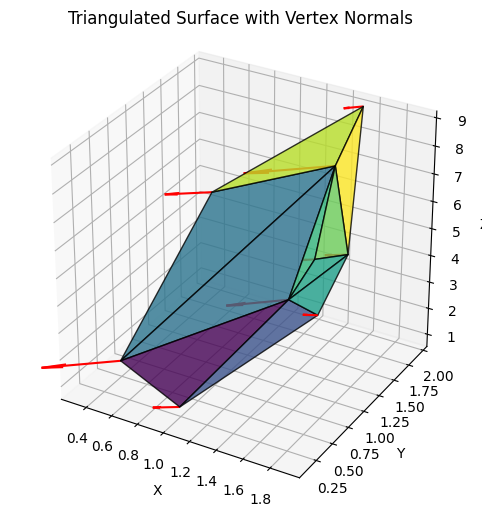

In [106]:
# Plot the triangulated surface in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1, 1, 1])
# Use plot_trisurf to create the surface
ax.plot_trisurf(lifted_points2[:, 0], lifted_points2[:, 1], lifted_points2[:, 2], triangles=tri_3D2.simplices, cmap='viridis', alpha=0.8, edgecolor='k')

vertex_norms = np.zeros(lifted_points2.shape)  #creating a copy to store the averaged values

for t in tri_3D2.simplices:
    p1 = lifted_points2[t[0]]
    p2 = lifted_points2[t[1]]
    p3 = lifted_points2[t[2]]
    normal = triangle_normal(p1, p2, p3) / 9.0     #3 is an arbitrary scale factor for aesthetics
    if(normal[2]<0):
        normal = normal*-1    #flip if facing downwards

    vertex_norms[t[0]] += normal
    vertex_norms[t[1]] += normal
    vertex_norms[t[2]] += normal

for i in range(len(vertex_norms)):
    v = vertex_norms[i]
    pt = lifted_points2[i]
    # Plot the normal vector
    ax.quiver(
        pt[0], pt[1], pt[2],  # Origin of the vector
        v[0], v[1], v[2],  # Direction of the vector
        color='red', length=0.4
    )

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Triangulated Surface with Vertex Normals')
plt.show()

In [107]:
# Analytical normal vector
def surface_normal2(x, y):
    # Compute the gradient of the lifting map
    # Gradient of f(x, y) = (df/dx, df/dy, -1) for the surface z = f(x, y)
    df_dx = 2*x + y**2
    df_dy = 2*x*y
    nx, ny, nz = df_dx, df_dy, -1  # The normal vector components
    norm = np.sqrt(nx**2 + ny**2 + nz**2)  # Normalize the vector
    return np.array([nx / norm, ny / norm, nz / norm])

# Predefined second derivatives of r(x, y)
def second_derivative_xx2(x, y):
    return np.array([2, 0, 0])  # d^2r/dx^2 = 2

def second_derivative_yy2(x, y):
    return np.array([0, 2*x, 0])  # d^2r/dy^2 = 2x (derivative of x * y^2 with respect to y)

def second_derivative_xy2(x, y):
    return np.array([0, 2*y, 0])  # d^2r/dxdy = 2y (derivative of x * y^2 with respect to x)

# Second fundamental form components
def second_fundamental_form2(x, y):
    n = surface_normal2(x, y)  # Surface normal at (x, y)
    L = -np.dot(n, second_derivative_xx2(x, y))  # Curvature in the x-direction
    M = -np.dot(n, second_derivative_xy2(x, y))  # Mixed curvature
    N = -np.dot(n, second_derivative_yy2(x, y))  # Curvature in the y-direction
    return L, M, N

second_form_values = []
for x, y in points_np2:  # points_np is the array of 2D points from your triangulation
    L, M, N = second_fundamental_form2(x, y)
    second_form_values.append((L, M, N))

# Convert to a NumPy array for easy processing
second_form_values = np.array(second_form_values)

# Example: Print a few values of (L, M, N)
print("First few second fundamental form values (L, M, N):")
print(second_form_values[:5])

First few second fundamental form values (L, M, N):
[[-1.54708894 -1.29512028 -1.94345811]
 [-1.85617361 -1.17204604 -0.23455144]
 [-1.56996713 -1.11398939 -2.26516105]
 [-1.7317222  -0.5129444  -1.68164493]
 [-1.49840966 -2.52609403 -2.00490736]]
